<a href="https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_Patch_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Patch Detection

This Colab notebook demos crude object detection by spliting an image into patches and finding the highest patch-caption similarity in CLIP embedding space.

In [7]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!pip install ftfy regex tqdm matplotlib
!pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import urllib.request
import matplotlib.pyplot as plt
import clip
from PIL import Image
from torchvision import transforms

In [8]:
#@title Helper functions

#@markdown Some helper functions for loading, patchifying and visualizing images.

def load_image(img_path, resize=None, pil=False):
    image = Image.open(image_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    if pil:
        return image
    return np.asarray(image).astype(np.float32) / 255.

def viz_patches(x, figsize=(20, 20), patch_idx=None, t=5):
    # x: num_patches, 3, patch_size, patch_size
    n = patches.shape[0]
    nrows = int(math.sqrt(n))
    fig, axes = plt.subplots(nrows, nrows, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):            
        im = x[i].permute(1, 2, 0).numpy()
        im = (im * 255.).round().astype(np.uint8)
        if patch_idx is not None and i == patch_idx:
            im[0:t] = (255, 0, 0)
            im[im.shape[0]-t:] = (255, 0, 0)
            im[:, 0:t] = (255, 0, 0)
            im[:, im.shape[1]-t:] = (255, 0, 0)
        ax.imshow(im)
        ax.axis("off")
    plt.show()

def patchify(image_path, resolution, patch_size, patch_stride=None):
    img_tensor = transforms.ToTensor()(load_image(image_path, resolution, True))
    if patch_stride is None:
        patch_stride = patch_size
    patches = img_tensor.unfold(
        1, patch_size, patch_stride).unfold(2, patch_size, patch_stride)
    patches = patches.reshape(3, -1, patch_size, patch_size).permute(1, 0, 2, 3)
    return patches  # N, 3, patch_size, patch_size

patches:  torch.Size([16, 3, 224, 224])


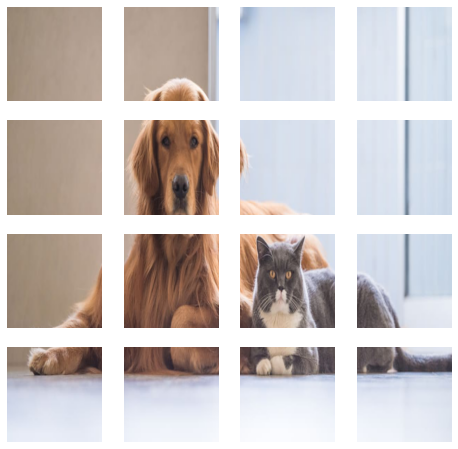

In [9]:
#@title Image and Patch Settings { run: "auto" }

image_url = 'https://images2.minutemediacdn.com/image/upload/c_crop,h_706,w_1256,x_0,y_64/f_auto,q_auto,w_1100/v1554995050/shape/mentalfloss/516438-istock-637689912.jpg' #@param {type:"string"}
image_resolution =  900#@param {type:"integer"}
patch_size =  224#@param {type:"integer"}
# integer_input = 10 #@param {type:"integer"}
# integer_slider = 21 #@param {type:"slider", min:0, max:100, step:1}

# Download the image from the web.
image_path = 'image.png'
urllib.request.urlretrieve(image_url, image_path)

patches = patchify(image_path, image_resolution, patch_size)
print("patches: ", patches.shape)
viz_patches(patches, figsize=(8, 8))

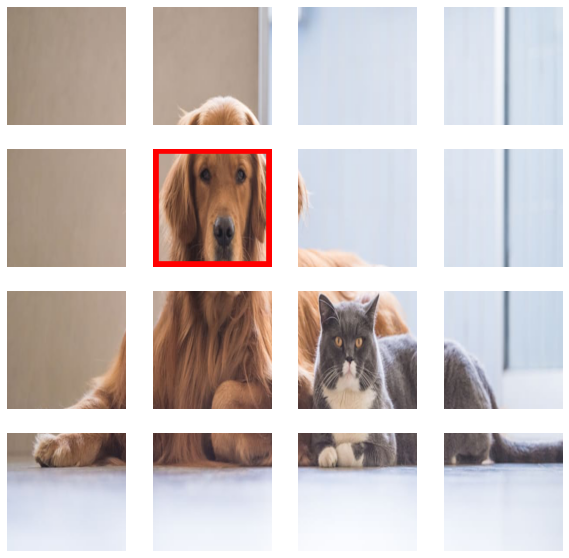

In [18]:
#@title Detect

clip_model = "RN101" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
image_caption = 'the dog' #@param {type:"string"}

# Load CLIP model.
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

text_input = clip.tokenize([image_caption]).to(device)

# Pad in case not equal to model expected input resolution.
p = model.visual.input_resolution - patch_size
patches_pad = torch.nn.functional.pad(
    patches, (p//2, p//2, p//2, p//2), "constant", 0).to(device)

with torch.no_grad():
    patch_embs = model.encode_image(patches_pad)
    text_embs = model.encode_text(text_input)
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
    idx_max = sim.argmax().item()

viz_patches(patches, figsize=(10, 10), patch_idx=idx_max, t=int(0.05*patch_size))